In [7]:
# Importing necessary lebraries
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as pl
import joblib
import seaborn as se
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import mlflow
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [8]:
sys.path.append(os.path.join(os.path.abspath('..')))
# Import modules
from src import data_loader as dl

In [9]:

sys.path.append(os.path.abspath("../"))


from scripts.model import prepare_data, split_data

from scripts.logger import logger 

In [10]:

credit = dl.load_data("creditcard.csv")
# Remove duplicates
credit = credit.drop_duplicates()
credit["Class"] = credit["Class"].astype(bool)



In [11]:
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,False
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,False
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,False
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,False
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,False


In [12]:
print('No frauds', round(credit['Class'].value_counts().iloc[0] / len(credit) * 100, 2), '% of the dataset')
print('Frauds', round(credit['Class'].value_counts().iloc[1] / len(credit) * 100, 2), '% of the dataset')

non_fraud_sum = credit[credit['Class'] == 0].value_counts().sum()
print('Non fraud', non_fraud_sum)

fraud_sum = credit[credit['Class'] == 1].value_counts().sum()
print('Fraud', fraud_sum)


No frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Non fraud 283253
Fraud 473


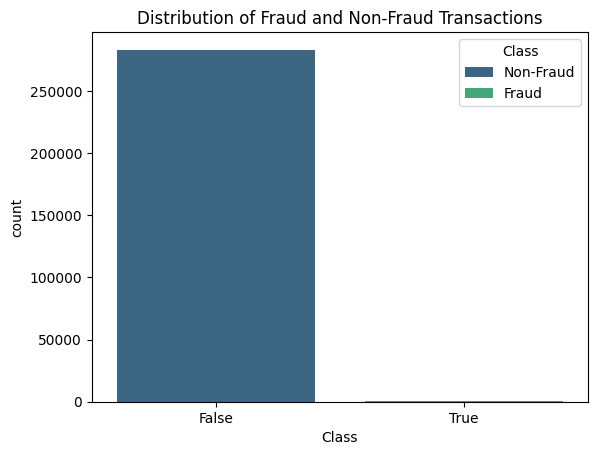

In [13]:
se.countplot(data=credit, x='Class', hue='Class', palette='viridis')
pl.legend(title='Class', labels=['Non-Fraud', 'Fraud'], loc='best')
pl.title('Distribution of Fraud and Non-Fraud Transactions')
pl.show()

dataset is highly imbalanced, with a very small percentage of fraudulent transactions compared to non-fraudulent ones.class imbalance can affect the performance of machine learning models. Models might become biased towards the majority class (non-fraudulent transactions), leading to poor detection of the minority class (fraudulent transactions)

To address the class imbalance issue, we'll undersample the majority class
Shuffle Dataset: Randomly shuffles the dataset to ensure randomness.

Isolate Minority Class (Fraud): Selects all fraud instances (473).

Sample Majority Class (Non-Fraud): Randomly selects 473 non-fraud instances to match the number of fraud cases.

Create Balanced Dataset: Combines the fraud and selected non-fraud instances, then shuffles the combined dataset to ensure randomness.

In [14]:

# to match the number of instances in the minority class.

# Randomly shuffle the entire dataset to ensure randomness
df = credit.sample(frac=1, random_state=42).reset_index(drop=True)

# Isolate the minority class (fraud) with 473 instances
minority_class = df.loc[df['Class'] == 1]

# Select a random subset of the majority class (non-fraud) with the same number of instances as the minority class
majority_class_subset = df.loc[df['Class'] == 0].sample(n=473, random_state=42)

# Combine the minority class and the majority class subset to create a balanced dataset
balanced_df = pd.concat([minority_class, majority_class_subset])

# Shuffle the balanced dataset to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the first few rows of the balanced dataset
balanced_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,14073.0,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,...,1.976988,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,1.00,True
1,55279.0,-5.753852,0.577610,-6.312782,5.159401,-1.698320,-2.683286,-7.934389,2.373550,-3.073079,...,1.177852,0.175331,-1.211123,-0.446891,-0.405520,-0.165797,1.505516,0.359492,1.00,True
2,45278.0,1.257581,0.389792,0.316394,0.688601,-0.329816,-1.062477,0.117713,-0.230186,-0.037977,...,-0.282539,-0.791483,0.124223,0.358095,0.232011,0.092895,-0.019934,0.031739,1.29,False
3,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,True
4,146022.0,0.908637,2.849024,-5.647343,6.009415,0.216656,-2.397014,-1.819308,0.338527,-2.819883,...,0.407260,-0.397435,-0.080006,-0.168597,0.465058,0.210510,0.648705,0.360224,1.18,True


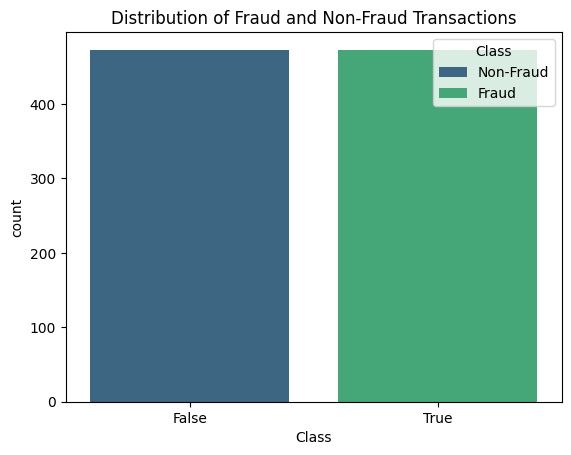

In [15]:
se.countplot(data=balanced_df, x='Class', hue='Class', palette='viridis')
pl.legend(title='Class', labels=['Non-Fraud', 'Fraud'], loc='best')
pl.title('Distribution of Fraud and Non-Fraud Transactions')
pl.show()

In [16]:

X_credit, y_credit = prepare_data(balanced_df, 'Class')

INFO:fraud_detection_logger:Preparing data by separating features and target column: Class


2025-07-20 15:37:27,705 - INFO - Preparing data by separating features and target column: Class


In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Convert the target variable to integer
credit['Class'] = credit['Class'].astype(int)

# Define the resampling strategies
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.1)

# Split data into features (X) and target (y)
X = credit.iloc[:, :-1].values  # Assuming 'Class' is the last column
y = credit['Class'].values

# Apply under-sampling first
X_under, y_under = under.fit_resample(X, y)

# Apply over-sampling on the under-sampled data
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

# Now you can use the resampled data for further processing
print(Counter(y_resampled))


Counter({np.int64(0): 4730, np.int64(1): 2365})


In [18]:
#  Train-Test Split
X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled, test_size=0.2, random_state=42)


INFO:fraud_detection_logger:Splitting data into train and test sets


2025-07-20 15:37:30,347 - INFO - Splitting data into train and test sets


In [19]:
# Train and evaluate Logistic Regression model for creditcard.csv
with mlflow.start_run(run_name="Logistic Regression - Fraud Data"):
    logistic_model = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')  # Increased max_iter & balanced class weights
    
    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')

    logistic_model.fit(X_train, y_train)  # Train the model
    y_pred_fraud = logistic_model.predict(X_test)  # Predict on test data

    # Generate classification report
    report_fraud = classification_report(y_test, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(logistic_model, "logistic_model_fraud", input_example=X_test[:5])

    # Print classification report
    print("Logistic Regression - Fraud Data:\n", classification_report(y_test, y_pred_fraud))


c:\Users\HP\Desktop\10 acd\week 8 -9\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2025/07/20 15:37:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logistic Regression - Fraud Data:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       974
           1       0.99      0.97      0.98       445

    accuracy                           0.99      1419
   macro avg       0.99      0.98      0.98      1419
weighted avg       0.99      0.99      0.99      1419



In [20]:

# Train and evaluate Decision Tree model creditcard.csv
with mlflow.start_run(run_name="Decision Tree - Fraud Data"):
    decision_tree_model = DecisionTreeClassifier()

    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')

    decision_tree_model.fit(X_train, y_train)  # Train the model
    y_pred_fraud = decision_tree_model.predict(X_test)  # Predict on test data

    # Generate classification report
    report_fraud = classification_report(y_test, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Decision Tree")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(decision_tree_model, "decision_tree_model_fraud", input_example=X_test[:5])

    # Print classification report
    print("Decision Tree - Fraud Data:\n", classification_report(y_test, y_pred_fraud))


2025/07/20 15:37:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Decision Tree - Fraud Data:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       974
           1       0.94      0.98      0.96       445

    accuracy                           0.97      1419
   macro avg       0.97      0.97      0.97      1419
weighted avg       0.97      0.97      0.97      1419



In [21]:

# Train and evaluate Random Forest model for creditcard.csv
with mlflow.start_run(run_name="Random Forest - Fraud Data"):
    random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')

    random_forest_model.fit(X_train, y_train)  # Train the model
    y_pred_fraud = random_forest_model.predict(X_test)  # Predict on test data

    # Generate classification report
    report_fraud = classification_report(y_test, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Random Forest")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(random_forest_model, "random_forest_model_fraud", input_example=X_test[:5])

    # Print classification report
    print("Random Forest - Fraud Data:\n", classification_report(y_test, y_pred_fraud))


2025/07/20 15:37:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Random Forest - Fraud Data:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       974
           1       1.00      0.97      0.98       445

    accuracy                           0.99      1419
   macro avg       0.99      0.98      0.99      1419
weighted avg       0.99      0.99      0.99      1419



In [22]:
# Train and evaluate Gradient Boosting model for creditcard.csv
with mlflow.start_run(run_name="Gradient Boosting - Fraud Data"):
    gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')

    gradient_boosting_model.fit(X_train, y_train)  # Train the model
    y_pred_fraud = gradient_boosting_model.predict(X_test)  # Predict on test data

    # Generate classification report
    report_fraud = classification_report(y_test, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "Gradient Boosting")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(gradient_boosting_model, "gradient_boosting_model_fraud", input_example=X_test[:5])

    # Print classification report
    print("Gradient Boosting - Fraud Data:\n", classification_report(y_test, y_pred_fraud))


2025/07/20 15:37:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Gradient Boosting - Fraud Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       974
           1       0.99      0.97      0.98       445

    accuracy                           0.99      1419
   macro avg       0.99      0.98      0.99      1419
weighted avg       0.99      0.99      0.99      1419



In [23]:
# Train and evaluate MLP model for creditcard.csv
with mlflow.start_run(run_name="MLP - Fraud Data"):
    mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=0.0001, solver='adam', random_state=42)

    # Ensure feature data is in float64 to avoid MLflow warnings
    X_train = X_train.astype('float64')
    X_test = X_test.astype('float64')

    mlp_model.fit(X_train, y_train)  # Train the model
    y_pred_fraud = mlp_model.predict(X_test)  # Predict on test data

    # Generate classification report
    report_fraud = classification_report(y_test, y_pred_fraud, output_dict=True)
    accuracy_fraud = report_fraud['accuracy']

    # Log parameters, metrics, and model
    mlflow.log_param("model", "MLP")
    mlflow.log_metric("accuracy", accuracy_fraud)
    mlflow.sklearn.log_model(mlp_model, "mlp_model_fraud", input_example=X_test[:5])

    # Print classification report
    print("MLP - Fraud Data:\n", classification_report(y_test, y_pred_fraud))


2025/07/20 15:38:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


MLP - Fraud Data:
               precision    recall  f1-score   support

           0       1.00      0.07      0.14       974
           1       0.33      1.00      0.50       445

    accuracy                           0.37      1419
   macro avg       0.67      0.54      0.32      1419
weighted avg       0.79      0.37      0.25      1419



Best Model for Fraud Detection: Random Forest
Why Random Forest:
Perfect Precision (1.00): This means that when the model predicts a transaction as fraud, it is almost always correct, which is critical in fraud detection to minimize false positives (false alarms).
High Recall (0.97): It still identifies 97% of actual fraud cases, which is excellent, though it's a bit lower than Logistic Regression's 0.98 recall. This means it may miss a few fraud cases, but it's still highly effective.
High F1-score (0.98): This shows a good balance between precision and recall, and overall performance.

In [25]:
import os
import joblib

# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the trained model to the 'models' folder with the name 'randomforestfor_credit_card_data.pkl'
joblib.dump(random_forest_model, 'models/randomforestfor_credit_card_data.pkl')


['models/randomforestfor_credit_card_data.pkl']